In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
import os
import glob
import nltk
from tqdm import tqdm
import warnings
warnings.siml('ignorewarnings')

# scilearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

TypeError: showwarning() missing 3 required positional arguments: 'category', 'filename', and 'lineno'

## The Goal
The general goal of this EDA is to attempt to tag the trails with only comments from the user. Therefore, we will be cleaning the trail data to use only user entries that have a comment related to their experience on the trail. This comment will help to classify the condition that the trail is in for the future data entries by the user. 

The more cleaner way of doing this is to hand label all there entries and use that for classification. 

In [260]:
csvs = []
for i in glob.glob("../Data/*.csv", recursive=True):
    csvs.append(i)

csvs

['../Data/adams-canyon-trail.csv',
 '../Data/scout-falls-trail.csv',
 '../Data/dog-lake-via-big-water-trail.csv',
 '../Data/lake-catherine-via-brighton-lakes-trail.csv',
 '../Data/lake-desolation-mill-d-north-trail.csv',
 '../Data/centerville-canyon-via-deuel-creek-trail.csv',
 '../Data/desolation-trail-to-salt-lake-overlook.csv',
 '../Data/waterfall-canyon-trail.csv',
 '../Data/grandeur-peak-east-trail-from-church-fork.csv',
 '../Data/horsetail-falls-trail.csv',
 '../Data/donut-falls-trail.csv',
 '../Data/battle-creek-falls.csv',
 '../Data/mt-timpanogos-timpooneke-trail.csv',
 '../Data/willow-heights-trail.csv',
 '../Data/bells-canyon-trail-to-lower-falls.csv',
 '../Data/fifth-water-hot-springs-trail.csv',
 '../Data/ferguson-canyon-trail-to-upper-meadow.csv',
 '../Data/cecret-lake-trail.csv',
 '../Data/lake-mary-trail.csv',
 '../Data/heughs-canyon-trail.csv']

Import all the csvs!

In [261]:
df = []
for i in csvs:
    ds = pd.read_csv(i)
    df.append(ds)

df = pd.concat((pd.read_csv(i) for i in csvs),axis=0, ignore_index=True, sort=False)

In [262]:
df.head()

,Unnamed: 0,Date,Tags,Comments,Unnamed: 4
0,0,2019-09-07,['hiking'],"Love Adams , love the waterfall, initial switc...",NaN
1,1,2019-09-06,['hiking'],Hiked this today with our 4 and 6 year old. A ...,NaN
2,2,2019-09-04,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.,NaN
3,3,2019-09-03,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ...",NaN
4,4,2019-09-02,['hiking'],The Sandy switch backs kinda kicks your butt i...,NaN


Couple of columns that we dont need! Unnamed, Dates, Unnamed 4. Lets remove them. 

In [263]:
# Drop the index column
df = df.drop(['Unnamed: 0','Unnamed: 4', 'Date'], axis=1)
df.head()

,Tags,Comments
0,['hiking'],"Love Adams , love the waterfall, initial switc..."
1,['hiking'],Hiked this today with our 4 and 6 year old. A ...
2,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.
3,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ..."
4,['hiking'],The Sandy switch backs kinda kicks your butt i...


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16608 entries, 0 to 16607
Data columns (total 2 columns):
Tags        16608 non-null object
Comments    7252 non-null object
dtypes: object(2)
memory usage: 259.6+ KB


As it can be seen, some of the rows dont have any comments. Also, some of the Tags are empty and only hav a ''. Lets remove these rows for now. 

In [265]:
print(df.shape)
clean_df = df[df['Comments'].notnull()]
print(clean_df.shape)

(16608, 2)
(7252, 2)


And empty tags will be removed next.

In [266]:
print(df.shape)
clean_df = df[(df['Comments'].notnull())&(df['Tags'] != "['']")]
print(clean_df.shape)

(16608, 2)
(4926, 2)


Lets make the comment section a little more clean.

In [267]:
# remove the brackets and quatations
def cleanit(text):
    # removing the backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove non alphabetical stuff
    text = re.sub("[^a-zA-Z]"," ", text)
    # remove the white spaces
    text = ' '.join(text.split())
    # all lowercase
    text = text.lower()
    return text

In [268]:
clean_df['comments'] = clean_df['Comments'].apply(lambda x: cleanit(x))
clean_df['tags'] = clean_df['Tags'].apply(lambda x: cleanit(x))

# Finally, make a list of tags
clean_df.tags = clean_df.tags.apply(lambda x: list(x.split()))

/home/fyousef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/fyousef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fyousef/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [269]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4926 entries, 0 to 16294
Data columns (total 4 columns):
Tags        4926 non-null object
Comments    4926 non-null object
comments    4926 non-null object
tags        4926 non-null object
dtypes: object(4)
memory usage: 192.4+ KB


#### Exploring Tags after cleaning
Let us explore the types of tags and their frequency in our data.

In [270]:
all_tag = sum(clean_df.tags,[])
len(set(all_tag))

43

In [271]:
all_tags = nltk.FreqDist(all_tag)
all_tags

FreqDist({'hiking': 4637, 'rocky': 262, 'muddy': 166, 'snow': 143, 'bugs': 110, 'scramble': 83, 'trail': 81, 'running': 66, 'backpacking': 54, 'walking': 38, ...})

In [272]:
gen_df = pd.DataFrame({'Tag':list(all_tags.keys()),'Count':list(all_tags.values())})

In [273]:
gen_df.head()

,Tag,Count
0,hiking,4637
1,trail,81
2,running,66
3,closed,6
4,bugs,110


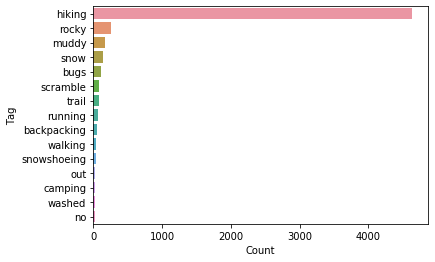

In [274]:
g = gen_df.nlargest(columns='Count', n=15)
plt.figure(figsize=(6,4)) 
ax = sns.barplot(data = g, x = 'Count', y = 'Tag')


plt.show()

We realize that we have bit of an imbalanced data. Lets keep an eye on it for when we model them. 

In [275]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [276]:
def remove_stopwords(text):
    no_SW = [w for w in text.split() if w not in stop_words]
    return ' '.join(no_SW)

In [277]:
clean_df['no_stopwords'] = clean_df['comments'].apply(lambda x: remove_stopwords(x))

/home/fyousef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [278]:
clean_df.head()

,Tags,Comments,comments,tags,no_stopwords
0,['hiking'],"Love Adams , love the waterfall, initial switc...",love adams love the waterfall initial switchba...,[hiking],love adams love waterfall initial switchbacks ...
1,['hiking'],Hiked this today with our 4 and 6 year old. A ...,hiked this today with our and year old a coupl...,[hiking],hiked today year old couple tricky spots overa...
2,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.,currently closed because of the snoqualmie fire,"[trail, running, closed]",currently closed snoqualmie fire
3,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ...",i did this trail on august th it was described...,"[hiking, bugs, scramble]",trail august th described much difficult actua...
4,['hiking'],The Sandy switch backs kinda kicks your butt i...,the sandy switch backs kinda kicks your butt i...,[hiking],sandy switch backs kinda kicks butt beginning ...


In [279]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

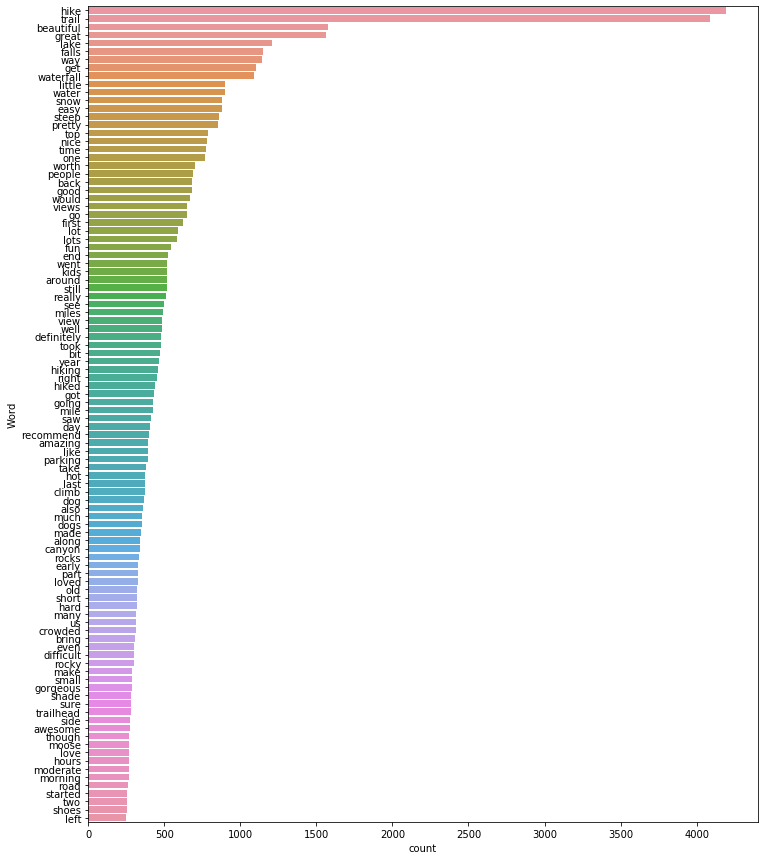

In [280]:
freq_words(clean_df['no_stopwords'], 100)

## Converting Text to Features

In [281]:
from sklearn.preprocessing import MultiLabelBinarizer

In [282]:
multilabel_bin = MultiLabelBinarizer()
multilabel_bin.fit(clean_df['tags'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [283]:
y = multilabel_bin.transform(clean_df['tags'])

In [284]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [285]:
xtrain, xval, ytrain, yval = train_test_split(clean_df['no_stopwords'], y, test_size=0.2, random_state=9)

In [286]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [287]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [288]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [289]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 26 is present in all training examples.
  str(classes[c]))
/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [290]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [291]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [292]:
multilabel_bin.inverse_transform(y_pred)[3]

('hiking',)

In [293]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.848234754699679

In [294]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [295]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [296]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.847985347985348

You might have noticed that the dataset is super biased to predict hiking. One way to fix this is to down-sample the comments that are just labeled with hiking. and re run the model.

In [297]:
clean_df['tags'].value_counts()

[hiking]                                         4151
[hiking, rocky]                                    92
[trail, running]                                   65
[backpacking]                                      53
[hiking, snow]                                     52
                                                 ... 
[skiing]                                            1
[muddy, rocky, snow]                                1
[hiking, over, grown, rocky, scramble]              1
[hiking, bridge, out, muddy, rocky, scramble]       1
[hiking, over, grown, scramble]                     1
Name: tags, Length: 106, dtype: int64

In [298]:
clean_df.head()

,Tags,Comments,comments,tags,no_stopwords
0,['hiking'],"Love Adams , love the waterfall, initial switc...",love adams love the waterfall initial switchba...,[hiking],love adams love waterfall initial switchbacks ...
1,['hiking'],Hiked this today with our 4 and 6 year old. A ...,hiked this today with our and year old a coupl...,[hiking],hiked today year old couple tricky spots overa...
2,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.,currently closed because of the snoqualmie fire,"[trail, running, closed]",currently closed snoqualmie fire
3,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ...",i did this trail on august th it was described...,"[hiking, bugs, scramble]",trail august th described much difficult actua...
4,['hiking'],The Sandy switch backs kinda kicks your butt i...,the sandy switch backs kinda kicks your butt i...,[hiking],sandy switch backs kinda kicks butt beginning ...


In [299]:
print(clean_df.shape)
selection = ['hiking']
mask = clean_df.tags.apply(lambda x: any(item for item in selection if item not in x))
clean1_df = clean_df[mask]
print(clean1_df.shape)

# select just hiking and only grab 289 sample
mask = clean_df.tags.apply(lambda x: any(item for item in selection if item in x))
clean2_df = clean_df[mask]
clean2_df = clean2_df.sample(n=600)
print(clean2_df.shape)

(4926, 5)
(289, 5)
(600, 5)


Merge the two datasets below.

In [300]:
cdf = clean1_df.append(clean2_df)
print(cdf.shape)
cdf.head()

(889, 5)


,Tags,Comments,comments,tags,no_stopwords
2,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.,currently closed because of the snoqualmie fire,"[trail, running, closed]",currently closed snoqualmie fire
94,['rocky'],"was way fun, took us about 2 1/2 hours, prepar...",was way fun took us about hours prepare to get...,[rocky],way fun took us hours prepare get wet feet
99,"['bugs', 'muddy', 'washed out']","Great trail, beautiful waterfalls. The water i...",great trail beautiful waterfalls the water is ...,"[bugs, muddy, washed, out]",great trail beautiful waterfalls water high do...
126,"['muddy', 'scramble', 'snow']","Took the kids for a quick, spring break hike. ...",took the kids for a quick spring break hike st...,"[muddy, scramble, snow]",took kids quick spring break hike still quite ...
153,['trail running'],Great hike / trail run. 3.9 miles from the Par...,great hike trail run miles from the parking lo...,"[trail, running]",great hike trail run miles parking lot hours g...


We are ready to train the model again.

In [301]:
from sklearn.preprocessing import MultiLabelBinarizer

In [302]:
multilabel_bin = MultiLabelBinarizer()
multilabel_bin.fit(cdf['tags'])

y = multilabel_bin.transform(cdf['tags'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [303]:
xtrain, xval, ytrain, yval = train_test_split(cdf['no_stopwords'], y, test_size=0.2, random_state=9)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [304]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [305]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/fyousef/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [306]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [307]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [308]:
multilabel_bin.inverse_transform(y_pred)[3]

('hiking',)

In [309]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.5849056603773585

In [310]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [311]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [312]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5807962529274004